# Guide walk-through

In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [10]:
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import math, copy, time
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")

In [11]:
%matplotlib inline

In [3]:
print(torch.device('cuda:0'))

cuda:0


In [12]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
    
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)
    
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)
    
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2    
    
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))    
    
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)
    
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)
    
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)
    
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)
    
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))
    
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)
    
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        # x = x + Variable(self.pe[:, :x.size(1)], 
        #                 requires_grad=False)
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)            

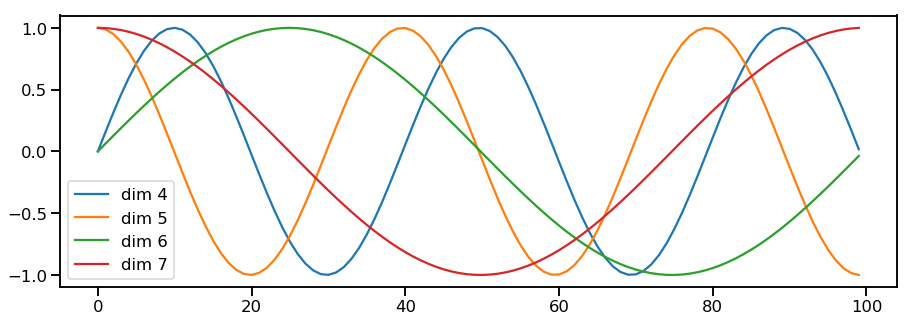

In [13]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

In [14]:
def make_model(src_vocab,
               tgt_vocab,
               N=6, 
               d_model=512,
               d_ff=2048,
               h=8,
               dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

In [15]:
tmp_model = make_model(10, 10, 2)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [16]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

In [17]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

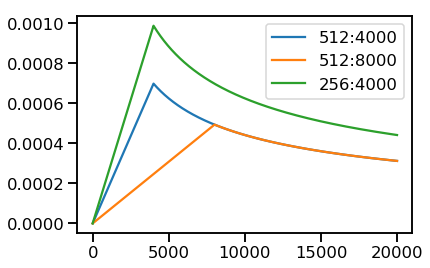

In [18]:
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])

In [19]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if len(mask) > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        # return self.criterion(x, Variable(true_dist, requires_grad=False))
        return self.criterion(x, true_dist)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  


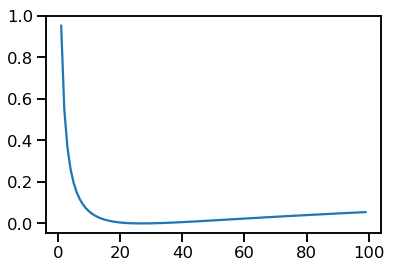

In [17]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d],
                                 ])
    # print(predict)
    return crit(Variable(predict.log()),
                 Variable(torch.LongTensor([1]))).data[0]
plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])

In [20]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

In [21]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data[0] * norm

In [55]:
batch.src.shape

torch.Size([30, 10])

In [41]:
for i, batch in enumerate(data_gen(11, 30, 20)):
    print(i)
    print(batch)
    break

0


In [43]:
batch.src.shape

torch.Size([30, 10])

In [42]:
batch.src_mask.shape

torch.Size([30, 1, 10])

In [22]:
batch.trg.type()

'torch.LongTensor'

In [27]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum().float()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

In [28]:
# Train the simple copy task.
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model, 
              SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_epoch(data_gen(V, 30, 5), model, 
                    SimpleLossCompute(model.generator, criterion, None)))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  0%|          | 0/50 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  app.launch_new_instance()
  0%|          | 0/50 [00:00<?, ?it/s]

tensor(1.8210)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor(1.6651)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor(1.4558)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor(1.2034)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor(0.9918)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor(0.7260)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor(0.4905)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor(0.4163)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor(0.2203)


 10%|█         | 5/50 [00:03<00:27,  1.62it/s, loss=tensor(0.2876), tkns_per_sec=tensor(593.4243)]

tensor(0.2457)


In [2]:
import torch

In [9]:
torch.rand(1,10,512).squeeze(dim=0).permute(1,0).shape

torch.Size([512, 10])

In [33]:
src.shape

torch.Size([2, 10])

In [39]:
src.shape

torch.Size([2, 10])

In [40]:
src_mask.shape

torch.Size([2, 1, 10])

In [49]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    batch_size = src.size(0)
    memory = model.encode(src, src_mask)
    print(memory.shape)
    ys = torch.ones(batch_size, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           ys, 
                           subsequent_mask(ys.size(1)).type_as(src.data))
        # prob = model.generator(out[:, -1])
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(batch_size, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

model.eval()
src = Variable(torch.LongTensor([[1,2,3,4,5,6,7,8,9,10],[1,2,3,4,5,6,7,8,9,10]]) )
src_mask = Variable(torch.ones(2, 1, 10) )
_ = greedy_decode(model, src, src_mask, max_len=10, start_symbol=1)
print(_)

torch.Size([2, 10, 512])
tensor([[  1,   2,   3,   4,   5,   6,   7,   8,   9,  10],
        [  1,   2,   3,   4,   5,   6,   7,   8,   9,  10]])


In [50]:
_.shape

torch.Size([2, 10])

# Real life example

In [10]:
# basic imports
import re
import gc
import ast
import copy
import time
import math
import glob
import os,sys
import shutil
import pickle
import argparse
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm

# torch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torchtext import data, datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau

# task specific custom modules
from pytorch.encoder_decoder import make_model
from pytorch.transformer_train_utils import str2bool
from pytorch.encoder_decoder_utils import (Batch,rebatch,
                                           SimpleLossCompute,
                                           cleaner,
                                           tokenize,
                                           greedy_decode_batch,
                                           beam_decode_batch,
                                           lookup_words,
                                           run_epoch
                                           )

from pytorch.metrics import (score_task1,
                             score_task2)

# utils
from tensorboardX import SummaryWriter

In [11]:
args = type('test', (object,), {})()

# args.resume = 'weights/encdec_savva_l4_heavy_h512e512_1e4_resume1e5_best.pth.tar'
# args.batch_size = 512
# args.hidden_size = 512
# args.num_layers = 4
# args.num_classes = 3
# args.emb_size = 512
# args.cn_emb_size = 0
# args.num_cn = 0
# args.heavy_decoder = True
# args.add_input_skip = True

args.tb_name = 'transformer_test'

args.train_df_path='../data/proc_train.csv'
args.trn_df_path='../data/proc_trn.csv'
args.val_df_path='../data/proc_val.csv'
args.test_df_path='../data/proc_test.csv'

args.min_freq = 0
args.dropout = 0.1

In [12]:
LOWER = False
BOS_WORD = '['
EOS_WORD = ']'
BLANK_WORD = "!"
MAX_LEN = 100
MIN_FREQ = 1

ID = data.Field(sequential=False,
                use_vocab=False)

NAMES = data.Field(tokenize=tokenize,
                   batch_first=True,
                   lower=LOWER,
                   include_lengths=True,
                   pad_token=BLANK_WORD,
                   init_token=None,
                   eos_token=EOS_WORD)

TRG_NAMES = data.Field(tokenize=tokenize, 
                       batch_first=True,
                       lower=LOWER,
                       include_lengths=True,
                       pad_token=BLANK_WORD,
                       init_token=BOS_WORD,
                       eos_token=EOS_WORD)

LBL = data.Field(sequential=False,
                 use_vocab=False)

CNT = data.Field(sequential=False,
                 use_vocab=False)

datafields = [("id", ID),
              ("src", NAMES),
              ("trg", TRG_NAMES),
              ("clf", LBL),
              ("cn", CNT)
             ]


trainval_data = data.TabularDataset(path=args.train_df_path,
                                 format='csv',
                                 skip_header=True,
                                 fields=datafields)    

MIN_FREQ = args.min_freq  # NOTE: we limit the vocabulary to frequent words for speed
NAMES.build_vocab(trainval_data.src, min_freq=MIN_FREQ)
TRG_NAMES.build_vocab(trainval_data.trg, min_freq=MIN_FREQ)
PAD_INDEX = TRG_NAMES.vocab.stoi[BLANK_WORD]

del trainval_data
gc.collect()


train_data = data.TabularDataset(path=args.trn_df_path,
                               format='csv',
                               skip_header=True,
                               fields=datafields)

val_data = data.TabularDataset(path=args.val_df_path,
                               format='csv',
                               skip_header=True,
                               fields=datafields)    


In [13]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0,
                 id=None,clf=None):
        self.id = id
        self.clf = clf
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum().float()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        # tgt_mask = tgt_mask & Variable(
        #    subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data)
        return tgt_mask

"""
def rebatch(pad_idx, batch):
    "Fix order in torchtext to match ours"
    src, trg = batch.src.transpose(0, 1), batch.trg.transpose(0, 1)
    return Batch(src, trg, pad_idx,
                 batch.id,batch.clf)
"""
def rebatch(pad_idx, batch):
    "Fix order in torchtext to match ours"
    # src, trg = batch.src.transpose(0, 1), batch.trg.transpose(0, 1)
    src, trg = batch.src[0], batch.trg[0]
    return Batch(src, trg, pad_idx,
                 batch.id,batch.clf)

In [17]:
# Skip if not interested in multigpu.
class MultiGPULossCompute:
    "A multi-gpu loss compute and train function."
    def __init__(self, generator, criterion, devices, opt=None, chunk_size=5):
        # Send out to different gpus.
        self.generator = generator
        self.criterion = nn.parallel.replicate(criterion, 
                                               devices=devices)
        self.opt = opt
        self.devices = devices
        self.chunk_size = chunk_size
        
    def __call__(self, out, targets, normalize):
        total = 0.0
        generator = nn.parallel.replicate(self.generator, 
                                                devices=self.devices)
        out_scatter = nn.parallel.scatter(out, 
                                          target_gpus=self.devices)
        out_grad = [[] for _ in out_scatter]
        targets = nn.parallel.scatter(targets, 
                                      target_gpus=self.devices)

        # Divide generating into chunks.
        chunk_size = self.chunk_size
        for i in range(0, out_scatter[0].size(1), chunk_size):
            # Predict distributions
            # out_column = [[Variable(o[:, i:i+chunk_size].data, 
            #                         requires_grad=self.opt is not None)] 
            #                for o in out_scatter]
            
            out_column = [[o[:, i:i+chunk_size]] 
                           for o in out_scatter]            
            
            gen = nn.parallel.parallel_apply(generator, out_column)

            # Compute loss. 
            y = [(g.contiguous().view(-1, g.size(-1)), 
                  t[:, i:i+chunk_size].contiguous().view(-1)) 
                 for g, t in zip(gen, targets)]
            loss = nn.parallel.parallel_apply(self.criterion, y)

            # Sum and normalize loss
            l = nn.parallel.gather(loss, 
                                   target_device=self.devices[0])
            l = l.sum()[0] / normalize
            total += l.data[0]

            # Backprop loss to output of transformer
            if self.opt is not None:
                l.backward()
                for j, l in enumerate(loss):
                    out_grad[j].append(out_column[j][0].grad.data.clone())

        # Backprop all loss through transformer.            
        if self.opt is not None:
            # out_grad = [Variable(torch.cat(og, dim=1)) for og in out_grad]
            out_grad = [torch.cat(og, dim=1) for og in out_grad]
            o1 = out
            o2 = nn.parallel.gather(out_grad, 
                                    target_device=self.devices[0])
            o1.backward(gradient=o2)
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return total * normalize

In [14]:
args.batch_size = 64

In [15]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

In [28]:
torch.device("cuda:0")

device(type='cuda', index=0)

In [20]:
devices = [0, 1]

pad_idx = TRG_NAMES.vocab.stoi[BLANK_WORD]
model = make_model(len(NAMES.vocab), len(TRG_NAMES.vocab), N=6)

# model.cuda()
model.to(torch.device('cuda:0'))
criterion = LabelSmoothing(size=len(TRG_NAMES.vocab), padding_idx=pad_idx, smoothing=0.1)
criterion.to(torch.device('cuda:0'))
BATCH_SIZE = args.batch_size

train_iter = data.BucketIterator(train_data,
                                 batch_size=args.batch_size,
                                 train=True, 
                                 device=torch.device("cuda:0"),
                                 sort_within_batch=True, 
                                 sort_key=lambda x: (len(x.src), len(x.trg)),
                                 repeat=False)

valid_iter_batch = data.Iterator(val_data,
                           batch_size=args.batch_size,
                           train=False,
                           device=torch.device("cuda:0"),
                           sort_within_batch=True,
                           sort_key=lambda x: (len(x.src), len(x.trg)),
                           repeat=False,
                           shuffle=False)

# model_par = nn.DataParallel(model, device_ids=devices)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [23]:
def run_epoch(data_iter, model, loss_compute,
              num_batches=50):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    
    with tqdm(total=num_batches) as pbar:
        for i, batch in enumerate(data_iter):
            out = model.forward(batch.src, batch.trg, 
                                batch.src_mask, batch.trg_mask)
            loss = loss_compute(out, batch.trg_y, batch.ntokens)
            total_loss += loss
            total_tokens += batch.ntokens
            tokens += batch.ntokens
            if i % 50 == 1:
                elapsed = time.time() - start

                # print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                #        (i, loss / batch.ntokens, tokens / elapsed))

                pbar.set_postfix(loss=(loss / batch.ntokens),
                                 tkns_per_sec=tokens / elapsed)            

                start = time.time()
                tokens = 0
            pbar.update(1)
    return total_loss / total_tokens

In [23]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data[0] * norm

In [1]:
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 2000,
                    torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    model.train()
    run_epoch((rebatch(pad_idx, b) for b in train_iter),
              model, 
              SimpleLossCompute(model.generator, criterion, model_opt),
              num_batches=len(train_iter))
    model.eval()
    print(run_epoch((rebatch(pad_idx, b) for b in valid_iter_batch),
                    model, 
                    SimpleLossCompute(model.generator, criterion, None),
                    num_batches=len(train_iter)))

NameError: name 'NoamOpt' is not defined

In [26]:
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 2000,
                    torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    model.train()
    run_epoch((rebatch(pad_idx, b) for b in train_iter),
              model, 
              SimpleLossCompute(model.generator, criterion, model_opt),
              num_batches=len(train_iter))
    model.eval()
    print(run_epoch((rebatch(pad_idx, b) for b in valid_iter_batch),
                    model, 
                    SimpleLossCompute(model.generator, criterion, None),
                    num_batches=len(train_iter)))

  0%|          | 0/28000 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  app.launch_new_instance()
  1%|          | 221/28000 [00:31<1:06:04,  7.01it/s, loss=tensor(0.1902, device='cuda:0'), tkns_per_sec=tensor(13096.5615, device='cuda:0')]                     


KeyboardInterrupt: 

In [24]:
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 2000,
                    torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    model_par.train()
    run_epoch((rebatch(pad_idx, b) for b in train_iter), 
              model_par, 
              MultiGPULossCompute(model.generator, criterion, 
                                  devices=devices, opt=model_opt),
              num_batches=len(train_iter))
    
    model_par.eval()
    
    loss = run_epoch((rebatch(pad_idx, b) for b in valid_iter_batch), 
                      model_par, 
                      MultiGPULossCompute(model.generator, criterion,
                                          devices=devices, opt=None),
                     num_batches=len(valid_iter_batch)
                     )
    print(loss)


  0%|          | 0/28000 [00:00<?, ?it/s]


RuntimeError: dimension specified as 0 but tensor has no dimensions

In [ ]:
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 2000,
                    torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    model_par.train()
    run_epoch((rebatch(pad_idx, b) for b in train_iter), 
              model_par, 
              MultiGPULossCompute(model.generator, criterion, 
                                  devices=devices, opt=model_opt),
              num_batches=len(train_iter))
    
    model_par.eval()
    
    loss = run_epoch((rebatch(pad_idx, b) for b in valid_iter_batch), 
                      model_par, 
                      MultiGPULossCompute(model.generator, criterion,
                                          devices=devices, opt=None),
                     num_batches=len(valid_iter_batch)
                     )
    print(loss)

In [ ]:
    model_opt = NoamOpt(model.src_embed[0].d_model, 1, 2000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
    for epoch in range(10):
        model_par.train()
        run_epoch((rebatch(pad_idx, b) for b in train_iter), 
                  model_par, 
                  MultiGPULossCompute(model.generator, criterion, 
                                      devices=devices, opt=model_opt))
        model_par.eval()
        loss = run_epoch((rebatch(pad_idx, b) for b in valid_iter), 
                          model_par, 
                          MultiGPULossCompute(model.generator, criterion, 
                          devices=devices, opt=None))
        print(loss)
else:

In [53]:
294912/64/8

576.0

In [ ]:
10 x -1 x 8 x 64

# Test stand

In [1]:
%env CUDA_VISIBLE_DEVICES=0

In [2]:
# basic imports
import re
import gc
import ast
import copy
import time
import math
import glob
import os,sys
import shutil
import pickle
import argparse
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm

# torch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torchtext import data, datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau

# task specific custom modules
from pytorch.ann_transformer import make_model,subsequent_mask
from pytorch.transformer_train_utils import str2bool
from pytorch.encoder_decoder_utils import (cleaner,
                                           tokenize,
                                           lookup_words
                                           )
from pytorch.ann_transformer_utils import (Batch,rebatch,
                                           SimpleLossCompute,
                                           greedy_decode,
                                           run_epoch,
                                           NoamOpt,
                                           get_std_opt,
                                           LabelSmoothing
                                           )

from pytorch.metrics import (score_task1,
                             score_task2)

# utils
from tensorboardX import SummaryWriter


In [3]:
args = type('test', (object,), {})()

args.resume = 'weights/ann_transformer_h512_l2_h4_best.pth.tar'
args.num_layers = 2
args.hidden_size = 512
args.ff_size = 2048
args.att_heads = 4
args.dropout = 0.1
args.num_classes = 3
args.batch_size = 3

args.predict = False
args.evaluate = True

args.train_df_path='../data/proc_train.csv'
args.trn_df_path='../data/proc_trn.csv'
args.val_df_path='../data/proc_val.csv'
args.test_df_path='../data/proc_test.csv'

args.min_freq = 0

In [4]:
# global vars
best_met = 0
valid_minib_counter = 0

# args = parser.parse_args()

# we will use CUDA if it is available
USE_CUDA = torch.cuda.is_available()
DEVICE=torch.device('cuda:0') # or set to 'cpu'
print("CUDA:", USE_CUDA)
print(DEVICE)

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
os.environ["USE_CUDA"] = str(USE_CUDA)
    
label_writers = []

LOWER = False
BOS_WORD = '['
EOS_WORD = ']'
BLANK_WORD = "!"
MAX_LEN = 100
MIN_FREQ = 1

ID = data.Field(sequential=False,
                use_vocab=False)

NAMES = data.Field(tokenize=tokenize,
                   batch_first=True,
                   lower=LOWER,
                   include_lengths=True,
                   pad_token=BLANK_WORD,
                   init_token=None,
                   eos_token=EOS_WORD)

TRG_NAMES = data.Field(tokenize=tokenize, 
                       batch_first=True,
                       lower=LOWER,
                       include_lengths=True,
                       pad_token=BLANK_WORD,
                       init_token=BOS_WORD,
                       eos_token=EOS_WORD)

LBL = data.Field(sequential=False,
                 use_vocab=False)

CNT = data.Field(sequential=False,
                 use_vocab=False)

datafields = [("id", ID),
              ("src", NAMES),
              ("trg", TRG_NAMES),
              ("clf", LBL),
              ("cn", CNT)
             ]

trainval_data = data.TabularDataset(path=args.train_df_path,
                                 format='csv',
                                 skip_header=True,
                                 fields=datafields)    

if not args.predict and not args.evaluate:
    train_data = data.TabularDataset(path=args.trn_df_path,
                                   format='csv',
                                   skip_header=True,
                                   fields=datafields)

    val_data = data.TabularDataset(path=args.val_df_path,
                                   format='csv',
                                   skip_header=True,
                                   fields=datafields)

    print('Train length {}, val length {}'.format(len(train_data),len(val_data)))        

if args.predict:
    test_data = data.TabularDataset(path=args.test_df_path,
                                    format='csv',
                                    skip_header=True,
                                    fields=datafields)    

MIN_FREQ = args.min_freq  # NOTE: we limit the vocabulary to frequent words for speed
NAMES.build_vocab(trainval_data.src, min_freq=MIN_FREQ)
TRG_NAMES.build_vocab(trainval_data.trg, min_freq=MIN_FREQ)
PAD_INDEX = TRG_NAMES.vocab.stoi[BLANK_WORD]

del trainval_data
gc.collect()

if not args.predict and not args.evaluate:
    train_iter = data.BucketIterator(train_data,
                                     batch_size=args.batch_size,
                                     train=True, 
                                     sort_within_batch=True, 
                                     sort_key=lambda x: (len(x.src), len(x.trg)),
                                     repeat=False,
                                     device=DEVICE,
                                     shuffle=True)

    valid_iter_batch = data.Iterator(val_data,
                               batch_size=args.batch_size,
                               train=False,
                               sort_within_batch=True,
                               sort_key=lambda x: (len(x.src), len(x.trg)),
                               repeat=False, 
                               device=DEVICE,
                               shuffle=False)

    val_ids = []
    for b in valid_iter_batch:
        val_ids.extend(list(b.id.cpu().numpy()))

    print('Preparing data for validation')

    train_df = pd.read_csv('../data/proc_train.csv')
    train_df = train_df.set_index('id')

    # val_gts = train_df.loc[val_ids,'fullname_true'].values
    # val_ors = train_df.loc[val_ids,'fullname'].values
    # incorrect_idx = list(train_df[train_df.target==1].index.values)
    # incorrect_val_ids = list(set(val_ids).intersection(set(incorrect_idx)))
    # correct_val_ids = list(set(val_ids)-set(incorrect_val_ids))

    print('Making dictionaries')

    id2gt = dict(train_df['fullname_true'])
    id2clf_gt = dict(train_df['target'])
    val_gts = [id2gt[_] for _ in val_ids]
    val_clf_gts = [id2clf_gt[_] for _ in val_ids]    
    del train_df
    gc.collect()    

if args.evaluate:
    val_data = data.TabularDataset(path=args.val_df_path,
                                   format='csv',
                                   skip_header=True,
                                   fields=datafields)

    valid_iter_batch = data.Iterator(val_data,
                               batch_size=args.batch_size,
                               train=False,
                               sort_within_batch=True,
                               sort_key=lambda x: (len(x.src), len(x.trg)),
                               repeat=False, 
                               device=DEVICE,
                               shuffle=False)

    val_ids = []
    for b in valid_iter_batch:
        val_ids.extend(list(b.id.cpu().numpy()))

    print('Preparing data for validation')

    train_df = pd.read_csv('../data/proc_train.csv')
    train_df = train_df.set_index('id')

    print('Making dictionaries')

    id2gt = dict(train_df['fullname_true'])
    id2clf_gt = dict(train_df['target'])
    val_gts = [id2gt[_] for _ in val_ids]
    val_clf_gts = [id2clf_gt[_] for _ in val_ids]    
    del train_df
    gc.collect()

if args.predict:
    test_iter_batch = data.Iterator(test_data,
                                    batch_size=args.batch_size,
                                    train=False,
                                    sort_within_batch=True,
                                    sort_key=lambda x: (len(x.src), len(x.trg)),
                                    repeat=False, 
                                    device=DEVICE,
                                    shuffle=False)    



    test_ids = []
    for b in test_iter_batch:
        test_ids.extend(list(b.id.cpu().numpy()))         

    
model = make_model(len(NAMES.vocab),
                   len(TRG_NAMES.vocab),
                   N=args.num_layers,
                   d_model=args.hidden_size,
                   d_ff=args.ff_size,
                   h=args.att_heads,
                   dropout=args.dropout,
                   num_classes=args.num_classes,
                   )
model.to(DEVICE)

loaded_from_checkpoint = False

if args.resume:
    if os.path.isfile(args.resume):
        print("=> loading checkpoint '{}'".format(args.resume))
        checkpoint = torch.load(args.resume,
                                map_location='cpu')
        args.start_epoch = checkpoint['epoch']
        best_met = checkpoint['best_met']
        model.load_state_dict(checkpoint['state_dict'])           
        print("=> loaded checkpoint (epoch {})".format(checkpoint['epoch']))

        loaded_from_checkpoint = True
        del checkpoint
        torch.cuda.empty_cache()
    else:
        print("=> no checkpoint found at '{}'".format(args.resume))
else:
    args.start_epoch = 0

CUDA: True
cuda:0
Preparing data for validation
Making dictionaries


/home/keras/notebook/nvme/cft_name/src/pytorch/ann_transformer.py:252: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


=> loading checkpoint 'weights/ann_transformer_h512_l2_h4_best.pth.tar'
=> loaded checkpoint (epoch 1)


In [5]:
valid_iter_batch = data.Iterator(val_data,
                           batch_size=256,
                           train=False,
                           sort_within_batch=True,
                           sort_key=lambda x: (len(x.src), len(x.trg)),
                           repeat=False, 
                           device=DEVICE,
                           shuffle=True)

val_ids = []
for b in valid_iter_batch:
    val_ids.extend(list(b.id.cpu().numpy()))

print('Preparing data for validation')

train_df = pd.read_csv('../data/proc_train.csv')
train_df = train_df.set_index('id')

print('Making dictionaries')

id2gt = dict(train_df['fullname_true'])
id2clf_gt = dict(train_df['target'])
val_gts = [id2gt[_] for _ in val_ids]
val_clf_gts = [id2clf_gt[_] for _ in val_ids]    
del train_df
gc.collect()

Preparing data for validation
Making dictionaries


21

In [55]:
torch.cuda.empty_cache()
gc.collect()

122

In [6]:
for batch in (rebatch(PAD_INDEX, b) for b in valid_iter_batch):
    break

In [23]:
NAMES.vocab.stoi[EOS_WORD],NAMES.vocab.stoi[BOS_WORD],NAMES.vocab.stoi[BLANK_WORD]

(2, 0, 1)

In [24]:
TRG_NAMES.vocab.stoi[BOS_WORD],TRG_NAMES.vocab.stoi[EOS_WORD],TRG_NAMES.vocab.stoi[BLANK_WORD]

(2, 3, 1)

In [11]:
val_gts[0:]

['О П Р', 'П П П', 'С С С']

In [24]:
val_gts[150]

'ОЖОГ ИВАН'

In [21]:
batch.src[500]

tensor([ 15,   9,  12,   6,  10,  11,  29,   2,   1,   1,   1], device='cuda:0')

In [16]:
model.eval()
count = 0

if NAMES.vocab is not None and TRG_NAMES.vocab is not None:
    src_eos_index = NAMES.vocab.stoi[EOS_WORD]
    trg_sos_index = TRG_NAMES.vocab.stoi[BOS_WORD]
    trg_eos_index = TRG_NAMES.vocab.stoi[EOS_WORD]
else:
    src_eos_index = None
    trg_sos_index = 1
    trg_eos_index = None

print('src_eos_index / trg_sos_index / trg_eos_index: {} / {} / {}'.format(src_eos_index,trg_sos_index,trg_eos_index))

preds = []
clf_preds = []

src_eos_index / trg_sos_index / trg_eos_index: 2 / 2 / 3


In [17]:
max_len = 50

In [76]:
def greedy_decode(model, src, src_mask, max_len, start_symbol,
                  return_logits=False, end_symbol=None):
    
    global DEVICE
    batch_size = src.size(0)
    
    # early stopping 
    break_mask = torch.zeros(batch_size).byte().to(DEVICE)
    prev_y_eos = torch.ones(batch_size).fill_(end_symbol).long().to(DEVICE)
    
    memory = model.encode(src, src_mask)
    clf_logits = model.classifier(memory)
    
    if return_logits:
        pred_classes = clf_logits
    else:
        _, pred_classes = torch.max(clf_logits, dim=1)    
    pred_classes = pred_classes.data.cpu().numpy()
    
    ys = torch.ones(batch_size, 1).fill_(start_symbol).type_as(src.data)
    
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           ys, 
                           subsequent_mask(ys.size(1)).type_as(src.data))
        # prob = model.generator(out[:, -1])
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)

        ys = torch.cat([ys, 
                        next_word.unsqueeze(dim=1)], dim=1)        
        
        mask = (next_word == prev_y_eos)
        break_mask += mask        
        
        if (break_mask>=1).sum()==batch_size:
            # print('Breaking out of cycle early')
            break            
    
    ys = ys.data.cpu().numpy()
    
    return ys,pred_classes

In [45]:
a.unsqueeze(dim=1).shape

torch.Size([256, 1])

In [43]:
a = torch.rand(256)

In [77]:
output, pred_classes = greedy_decode(
    model, batch.src, batch.src_mask,
    max_len,trg_sos_index,end_symbol=trg_eos_index
)

In [80]:
val_gts[201]

'НАКУ АЛА'

In [81]:
"".join(lookup_words(output[201],
                     vocab=TRG_NAMES.vocab))

'[НАКЦ АЛА]]] '

array([ 2, 48, 31, 53, 28, 31,  6, 38, 40, 23,  3,  3,  3,  6, 38, 40, 31,
       53, 28,  3, 40, 23,  3, 23,  3, 23,  3,  3,  3, 28,  3, 31,  6, 28,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3, 31,  3,  6, 23,  3, 31])

In [ ]:
        output, pred_classes = greedy_decode(
            model, batch.src, batch.src_mask,
            max_len,trg_sos_index
        )

        clf_preds.extend(list(pred_classes))

        # cut off everything starting from </s> 
        # (only when eos_index provided)
        if trg_eos_index is not None:
            # iterate over sentence predictions and cut off from eos
            for pred in output:
                first_eos = np.where(pred==trg_eos_index)[0]
                if len(first_eos) > 0:
                    # produce sentences
                    preds.append("".join(lookup_words(pred[:first_eos[0]],
                                     vocab=TRG_NAMES.vocab)))
                else:
                    preds.append("".join(lookup_words(pred[:],
                                                      vocab=TRG_NAMES.vocab)))                            
        pbar.update(1)

In [ ]:
def train(model,
          num_epochs=10,
          lr=1e-3,
          print_every=10,
          train_iter=None,
          valid_iter_batch=None,
          val_ids=None,
          val_clf_gts=None,
          val_gts=None,
          writer=None):
    
    global args
    global best_met
    global LOWER,PAD_INDEX,NAMES,TRG_NAMES
    global BOS_WORD,EOS_WORD,BLANK_WORD
    
    criterion = LabelSmoothing(size=len(TRG_NAMES.vocab), padding_idx=PAD_INDEX, smoothing=0.1)
    clf_criterion = nn.CrossEntropyLoss()

    optim = get_std_opt(model)
    
    """
    if args.load_optimizer_state:
        optim.load_state_dict(checkpoint['optimizer'])
    else:
        print('Optimizer state NOT loaded')     
    """

    for epoch in range(args.start_epoch, num_epochs):
      
        print("Epoch", epoch)
        print('Training the model')
        model.train()
        
        train_lm_loss, train_clf_loss = run_epoch((rebatch(PAD_INDEX, b) for b in train_iter), 
                                                  model,
                                                  SimpleLossCompute(model.generator,
                                                                    criterion,clf_criterion,
                                                                    optim,
                                                                    clf_coeff=args.clf_coeff),
                                                  print_every=print_every,
                                                  num_batches=len(train_iter),
                                                  epoch_no=epoch)
        
        model.eval()
        with torch.no_grad():
            print('Evaluating the model')

            dev_lm_loss, dev_clf_loss = run_epoch((rebatch(PAD_INDEX, b) for b in valid_iter_batch), 
                                                  model, 
                                                  SimpleLossCompute(model.generator,
                                                                    criterion, clf_criterion,
                                                                    None),
                                                     num_batches=len(valid_iter_batch),
                                                  epoch_no=epoch)

            preds,clf_preds = predict((rebatch(PAD_INDEX, x) for x in valid_iter_batch),
                                      model, max_len=70, src_vocab=NAMES.vocab, trg_vocab=TRG_NAMES.vocab,
                                      num_batches=len(valid_iter_batch)) 
            
            df_true = pd.DataFrame(
                {'id': val_ids,
                 'target': val_clf_gts,
                 'fullname_true':val_gts
                })
            df_pred = pd.DataFrame(
                {'id': val_ids,
                 'target': clf_preds,
                 'fullname_true':preds
                })

            score1 = score_task1(df_true, df_pred)
            score2 = score_task2(df_true, df_pred)
            score = (score1 + score2)/2
            
            print("Validation CLF Loss: %f" % dev_clf_loss)
            print("Validation LM Loss: %f" % dev_lm_loss)
            print("score {} / Score 1 {} / Score 2 {}".format(score,score1,score2))
            
            if args.tensorboard:
                writer.add_scalars('clf_losses', {'dev_clf_loss': dev_clf_loss,
                                                  'train_clf_loss': train_clf_loss},epoch+1) 

                writer.add_scalars('lm_losses', {'dev_lm_loss': dev_lm_loss,
                                                 'train_lm_loss': train_lm_loss},epoch+1)            

                writer.add_scalars('scores', {'score1': score1,
                                              'score2': score2,
                                              'score': score,},epoch+1)

            is_best = score > best_met
            best_acc1 = max(score, best_met)
            if not os.path.exists('weights/'):
                os.makedirs('weights/')
            save_checkpoint({
                    'epoch': epoch + 1,
                    'state_dict': model.state_dict(),
                    'best_met': best_met,
                    },
                    is_best,
                    'weights/{}_checkpoint.pth.tar'.format(str(tb_name)),
                    'weights/{}_best.pth.tar'.format(str(tb_name))
                    )
        
    return dev_lm_loss,dev_clf_loss,preds,clf_preds,score1,score2

def predict(example_iter, model, max_len=100, 
            sos_index=1, 
            src_eos_index=None, 
            trg_eos_index=None, 
            src_vocab=None, trg_vocab=None,
            num_batches=100):

    global args
    global best_met
    global LOWER,PAD_INDEX,NAMES,TRG_NAMES
    global BOS_WORD,EOS_WORD,BLANK_WORD
    
    model.eval()
    count = 0
    
    if src_vocab is not None and trg_vocab is not None:
        src_eos_index = src_vocab.stoi[EOS_WORD]
        trg_sos_index = trg_vocab.stoi[BOS_WORD]
        trg_eos_index = trg_vocab.stoi[EOS_WORD]
    else:
        src_eos_index = None
        trg_sos_index = 1
        trg_eos_index = None
        
    print('src_eos_index / trg_sos_index / trg_eos_index: {} / {} / {}'.format(src_eos_index,trg_sos_index,trg_eos_index))

    preds = []
    clf_preds = []
    
    with tqdm(total=num_batches) as pbar:
        for i, batch in enumerate(example_iter):
            
            output, pred_classes = greedy_decode(
                model, batch.src, batch.src_mask,
                max_len,trg_sos_index
            )

            clf_preds.extend(list(pred_classes))
            
            # cut off everything starting from </s> 
            # (only when eos_index provided)
            if trg_eos_index is not None:
                # iterate over sentence predictions and cut off from eos
                for pred in output:
                    first_eos = np.where(pred==trg_eos_index)[0]
                    if len(first_eos) > 0:
                        # produce sentences
                        preds.append("".join(lookup_words(pred[:first_eos[0]],
                                         vocab=TRG_NAMES.vocab)))
                    else:
                        preds.append("".join(lookup_words(pred[:],
                                                          vocab=TRG_NAMES.vocab)))                            
            pbar.update(1)
    return preds,clf_preds            